In [1]:
#plots optimal behavior figures

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

In [2]:
# generate trial stuff
vdict = {0: [5, 10, 20, 40, 80],
         1: [20, 40, 80],
         2: [5, 10, 20]}


seed = 101
ns = 10000 #number of trials
T = 100 #total time until violation
dt = 0.05 #timestep size
lam = 2.5 # wait time parameter
#lam = 10.0
Roo = -2.0 # optout penalty
#w = -0.5/dt # time penalty
w = -2.0
#pcatch = 0.05 #catch proability
pcatch = 0.2
ntmax = int(T / dt) + 1
tmesh = np.linspace(0, T, ntmax)  # time bins



In [94]:
#set up basic function for how to handle a trial


def topt_fun(R,ops):
    #uses optimal wait time formula to find time beyond which you should opt out
    pnocatch = 1.0-ops['pcatch']
    topt = ops['lambda']*(np.log(R*pnocatch) - np.log(-ops['w']*ops['lambda']))
    #topt = ops['lambda']*(np.log(R) - np.log(-ops['w']*ops['lambda']))
    topt_idx = np.digitize(topt, bins=ops['tmesh']) - 1 
    
    #allow for possible negative values with large time penalties
    return np.max([ops['dt'],topt])



def rho_lowlim(tlow,t,R,ops, sc=False):
    """ if sc=True, derive the self-consistent result in which k = rho"""
    
    lam = ops['lambda']
    pr = 1-ops['pcatch']
    
    #for now, do a very silly integration
    tmesh_t = np.linspace(tlow,t,1000)
    #tinf = 1000
    tinf = ops['tmesh'][-1]
    tmesh_inf = np.linspace(t,tinf,5000)
    dt = tmesh_t[1]-tmesh_t[0]
    dt_inf = tmesh_inf[1]-tmesh_inf[0]
    
    
    
    I1 = np.sum(np.exp(-tmesh_t/lam)/(lam*tmesh_t))*dt #correct
    I2 = np.sum(np.exp(-tmesh_inf/lam)/(lam*tmesh_inf))*dt 
    I3 = np.exp(-tlow/lam) - np.exp(-t/lam) # int_{tlow} ^t p(t') dt'
    
    C1 = pr*R*I1  #due to reward. correct
    C2 = pr*ops['Roo']*I2 #due to opt out on rewarded trial. correct
    C3 = (1-pr)*ops['Roo']/t #rate due to opt out on catch trial
    
    
    C_rew_w = pr*ops['w']*I3 # wait time penalty on rewarded trial
    C_optout_w = (1-pr)*ops['w'] # wait time penalty on catch trial
    
    if sc:
        denom = 2+pr*(I3-1)  # w--> rho, transforms C_rew_k and C_optout_k
        rho = (C1 + C2 + C3)/denom
    else:
        rho = C1 + C2 + C3 + C_rew_w + C_optout_w
    
    return rho, C1, C2, C3, C_rew_w, C_optout_w, I1

In [4]:
klist = np.linspace(0.01,4,100)
Rlist = np.linspace(0.0,90, 100)
nk = len(klist)
nr = len(Rlist)

tmat = np.zeros((nk,nr))

for k in range(nk):
    for r in range(nr):
        ops_k = {'lambda': lam, 
                 'Roo': Roo, 
                 'w': -klist[k], 
                 'pcatch':pcatch, 
                 'tmesh': tmesh, 
                 'dt':dt} #put all of the session data in here

        tmat[k,r] = topt_fun(Rlist[r],ops_k)
        

/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_20097/2382946722.py:7: RuntimeWarning: divide by zero encountered in log
  topt = ops['lambda']*(np.log(R*pnocatch) - np.log(-ops['w']*ops['lambda']))


In [5]:
#indices are approximate
kmixed_idx = 31
klow_idx = 5
khigh_idx = 56

In [28]:


ops = {'lambda': lam, 
         'Roo': Roo, 
         'w': -klist[klow_idx], 
         'pcatch':pcatch, 
         'tmesh': tmesh, 
         'dt':dt} #put all of the session data in here
topt_low = [topt_fun(k,ops) for k in [5,10,20]]

ops['w'] = -klist[khigh_idx]
topt_high = [topt_fun(k,ops) for k in [20,40,80]]

ops['w'] = -klist[kmixed_idx]
topt_mixed = [topt_fun(k,ops) for k in [5,10,20,40,80]]

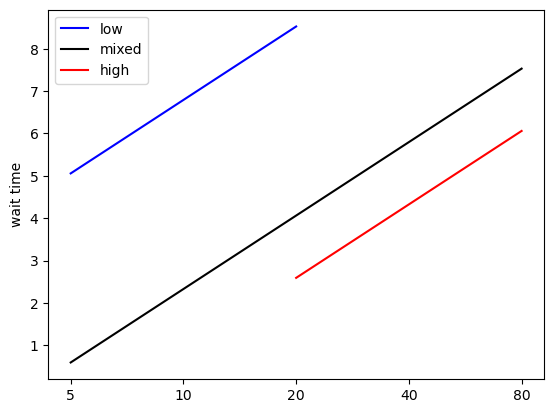

In [29]:
# Figure 2i

plt.plot([0,1,2],topt_low,color = 'b', label='low')
plt.plot([0,1,2,3,4],topt_mixed,color = 'k', label='mixed')
plt.plot([2,3,4],topt_high,color = 'r', label='high')
plt.legend()
plt.xticks([0,1,2,3,4],['5','10','20','40','80'])
plt.ylabel('wait time')
plt.show()

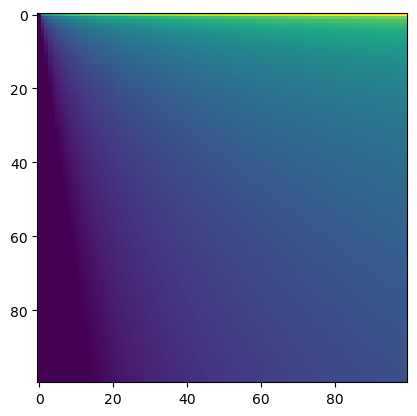

In [12]:
#surface plot 2i, thought was done in matlab
X, Y = np.meshgrid(klist, Rlist)
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X,Y,tmat)
plt.imshow(tmat)


In [95]:
# self-consistent optimization for wait times, Supp fig 8

nstep = 5
tlow = 0.05 # lower limit of time integration for exponential integrals. think of it as minimal reaction time?
Roo = -5.0


ops = {'lambda': lam, 
         'Roo': Roo, 
         'w': -klist[klow_idx], 
         'pcatch':pcatch, 
         'tmesh': tmesh, 
         'dt':dt} #put all of the session data in here

#original guess for k
wvec = [-0.2]
rhovec = []


for j in range(nstep):
    ops['w'] = wvec[-1]
    
    #average offer for mixed block
    rav = 0.2*(5+10+20+40+80)
    # optimal wait time for that offer
    topt_rav = topt_fun(rav, ops)
    #print(topt_rav)
    
    
    rho, C1, C2, C3, C_rew_w, C_optout_w, I1 = rho_lowlim(tlow,topt_rav,rav,ops, sc=False)
    print(rho)
    rhovec.append(rho)
    
    wvec.append(-rho*ops['dt'])
    #print(wvec[-1])
    
    
    
 
# for low blocks
wvec_low = [-0.2]
rhovec_low = []


for j in range(nstep):
    ops['w'] = wvec_low[-1]
    
    #average offer for mixed block
    rav = 1/3*(5+10+20)
    # optimal wait time for that offer
    topt_rav = topt_fun(rav, ops)
    #print(topt_rav)
    
    
    rho, C1, C2, C3, C_rew_w, C_optout_w, I1 = rho_lowlim(tlow,topt_rav,rav,ops, sc=False)
    print(rho)
    rhovec_low.append(rho)
    
    wvec_low.append(-rho*ops['dt'])
    #print(wvec[-1])
    
 

# for high blocks
wvec_high = [-0.2]
rhovec_high = []


for j in range(nstep):
    ops['w'] = wvec_high[-1]
    
    #average offer for mixed block
    rav = 1/3*(20+40+80)
    # optimal wait time for that offer
    topt_rav = topt_fun(rav, ops)
    #print(topt_rav)
    
    
    rho, C1, C2, C3, C_rew_w, C_optout_w, I1 = rho_lowlim(tlow,topt_rav,rav,ops, sc=False)
    print(rho)
    rhovec_high.append(rho)
    
    wvec_high.append(-rho*ops['dt'])
    #print(wvec[-1])
    

33.91315425734662
33.6649032805075
33.66979045872214
33.66969410862249
33.66969600809831
12.409651879865779
12.602289515058112
12.598111887756506
12.598202212055389
12.598200259030621
51.39817286338615
50.732412546629
50.745248634015695
50.745000515226806
50.745005311070706


In [96]:
ops_scf_mixed = {'lambda': lam, 
         'Roo': Roo, 
         'w': wvec[-1], 
         'pcatch':pcatch, 
         'tmesh': tmesh, 
         'dt':dt} #put all of the session data in here
topt_mixed_scf = [topt_fun(k,ops_scf_mixed) for k in [5,10,20,40,80]]


ops_scf_low = {'lambda': lam, 
         'Roo': Roo, 
         'w': wvec_low[-1], 
         'pcatch':pcatch, 
         'tmesh': tmesh, 
         'dt':dt} #put all of the session data in here
topt_low_scf = [topt_fun(k,ops_scf_low) for k in [5,10,20]]



ops_scf_high = {'lambda': lam, 
         'Roo': Roo, 
         'w': wvec_high[-1], 
         'pcatch':pcatch, 
         'tmesh': tmesh, 
         'dt':dt} #put all of the session data in here
topt_high_scf = [topt_fun(k,ops_scf_high) for k in [20,40,80]]

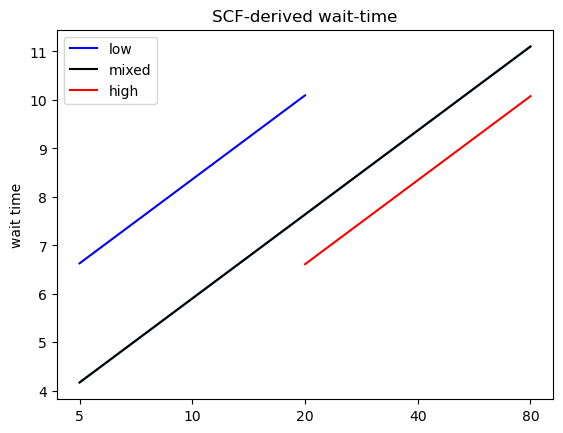

In [97]:
plt.plot(topt_mixed_scf)

plt.plot([0,1,2],topt_low_scf,color = 'b', label='low')
plt.plot([0,1,2,3,4],topt_mixed_scf,color = 'k', label='mixed')
plt.plot([2,3,4],topt_high_scf,color = 'r', label='high')
plt.legend()
plt.xticks([0,1,2,3,4],['5','10','20','40','80'])
plt.ylabel('wait time')
plt.title('SCF-derived wait-time')
plt.show()